In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)

0.5%

100.1%

Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz


180.4%

Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [10]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [11]:
image, label = train_data[0]

In [12]:
image.shape

torch.Size([1, 28, 28])

In [13]:
label

5

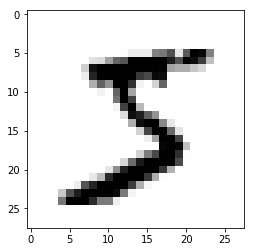

In [17]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg') # viridis is the defult colormap

In [18]:
torch.manual_seed(101)

train_loader = DataLoader(train_data,batch_size=100,shuffle=True)

test_loader = DataLoader(test_data,batch_size=500,shuffle=False)

In [19]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # formatting

In [20]:
# first batch
for images, labels in train_loader:
    break

In [21]:
images.shape

torch.Size([100, 1, 28, 28])

In [22]:
labels.shape

torch.Size([100])

Labels:  [   1    3    6    5    7    6    6    5    6    3    1    6]


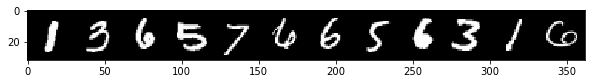

In [23]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [46]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)      

In [47]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [50]:
images.shape

torch.Size([100, 1, 28, 28])

In [51]:
images.view(100,-1).shape

torch.Size([100, 784])

In [53]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.21733159  accuracy:  83.195%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.22434179  accuracy:  87.740%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.21169330  accuracy:  89.720%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.19045883  accuracy:  95.010%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.14187005  accuracy:  95.190%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.11203356  accuracy:  95.405%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.07773186  accuracy:  96.645%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.08321012  accuracy:  96.733%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.06792030  accuracy:  96.812%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.15763092  accuracy:  97.480%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.09766731  accuracy:  97.505%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.15211515  accuracy:  97.580%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.04443396  accuracy:  98.035%
epoch:  4  b

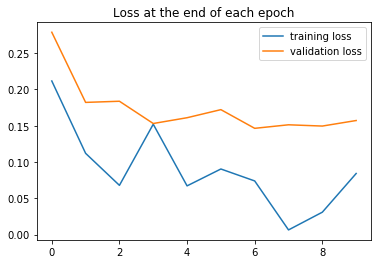

In [54]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

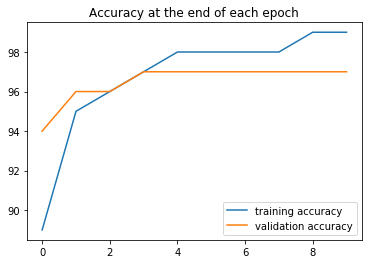

In [55]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [56]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9442), tensor(9661), tensor(9653), tensor(9726), tensor(9735), tensor(9741), tensor(9747), tensor(9731), tensor(9746), tensor(9768)]

Test accuracy: 97.680%


In [57]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [58]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9768/10000 =  97.680%


In [59]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    2    2    2    3    2    0    7    2]
 [   0 1119    0    0    0    0    3    3    0    1]
 [   1    4 1015   10    2    0    3   13    4    0]
 [   1    2    1  984    0   14    0    4    1    3]
 [   1    0    3    0  955    2    4    0    4    5]
 [   0    1    0    3    0  855    2    0    2    5]
 [   4    2    2    0    4    8  943    0    4    0]
 [   0    1    3    2    3    0    0  994    4    0]
 [   3    6    5    6    1    4    1    4  944    3]
 [   1    0    1    3   15    6    0   10    4  990]]


In [60]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

232

In [61]:
misses[:10]

array([ 104,  115,  149,  151,  158,  247,  274,  321,  340,  445])

In [62]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [ 104  115  149  151  158  247  274  321  340  445  447  449]
Label: [   9    4    2    9    3    4    9    2    5    6    4    3]
Guess: [   5    9    4    8    2    6    3    7    3    0    9    5]


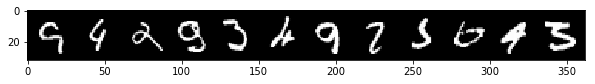

In [63]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));